In [386]:
import pandas as pd
import concurrent.futures
import requests
import time
import numpy as np
import glob2 as glob
from unidecode import unidecode
import os
import logging
import cv2
import squarify
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

In [387]:
csv = pd.read_csv('annotations.csv')

In [388]:
csv['CM'] = (csv['configuracao_mao']).str.rsplit('/', 1).map(lambda x: x[1])
csv['CM'] = (csv['CM']).str.rsplit('.', 1).map(lambda x: x[0])

csv['filename'] = csv['filename'].map(lambda x:unidecode(x))
csv['filename'][652] = csv['filename'][652].rsplit('/', 1)[1]
csv['filename'][653] = csv['filename'][653].rsplit('/', 1)[1]

csv['palavra'] = (csv['filename']).map(lambda x:unidecode(x))
csv['palavra'] = (csv['palavra']).str.rsplit('.', 1).map(lambda x: x[0])
# csv.to_csv('processedAnnotations.csv', index=False)

In [389]:
csv = csv.set_index('palavra')

In [390]:
csv.loc['BANDEIRANTE']['classe_gramatical'] = 'SUBSTANTIVO'
csv.loc['CEGO']['classe_gramatical'] = 'ADJETIVO'
csv.loc['CHEFE']['classe_gramatical'] = 'SUBSTANTIVO'
csv.loc['FEIJAO']['classe_gramatical'] = 'SUBSTANTIVO'
csv.loc['ADULTO']['classe_gramatical'] = 'SUBSTANTIVO'
csv.loc['DESEMPREGADO']['classe_gramatical'] = 'ADJETIVO'
csv.loc['MARROM']['classe_gramatical'] = 'ADJETIVO'
csv.loc['SOCIO']['classe_gramatical'] = 'SUBSTANTIVO'

In [391]:
csv2 = csv.copy()
csv2['len_palavra'] = csv2.index.map(lambda x:len(x))
csv2 = csv2[csv2['len_palavra'] > 0]
csv2 = csv2.drop(['video_url', 'configuracao_mao', 'filename', 'len_palavra'], axis=1)
csv2['letra'] = csv2.index.map(lambda x:x[0])

In [392]:
countLetters = csv2.groupby(['letra']).count()['CM']
# countLetters.to_csv('countWordsPerLetter.csv')
countCM = csv2.groupby(['CM']).count()['letra']
# countCM.to_csv('countWordsPerCM.csv')
countCG = csv2.groupby(['classe_gramatical']).count()['CM']
# countCM.to_csv('countWordsPerCG.csv')

### Visualizing data

In [393]:
import seaborn as sns
countLetters = countLetters.sort_values(ascending=False)
countCM = countCM.sort_values(ascending=False)
cmap = matplotlib.cm.tab20
colors1 = sns.light_palette("Tomato", 26, reverse=True)
colors2 = sns.light_palette("Tomato", 73, reverse=True)

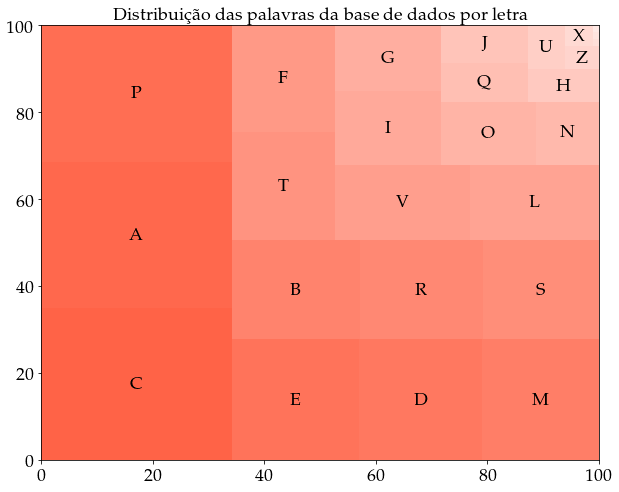

In [383]:
#Create our plot and resize it.
fig = plt.gcf()
fig.set_size_inches(10, 8)

values = countLetters.values
labels = countLetters.index.values
labels[values == 1] = ""

squarify.plot(sizes=countLetters.values, label=labels, color=colors1, text_kwargs={'fontsize':18})
plt.title('Distribuição das palavras da base de dados por letra', fontsize=18)
plt.tick_params(labelsize=18)
# plt.axis()
plt.show()
fig.savefig('treemap_letters.eps', format='eps', dpi=1200)

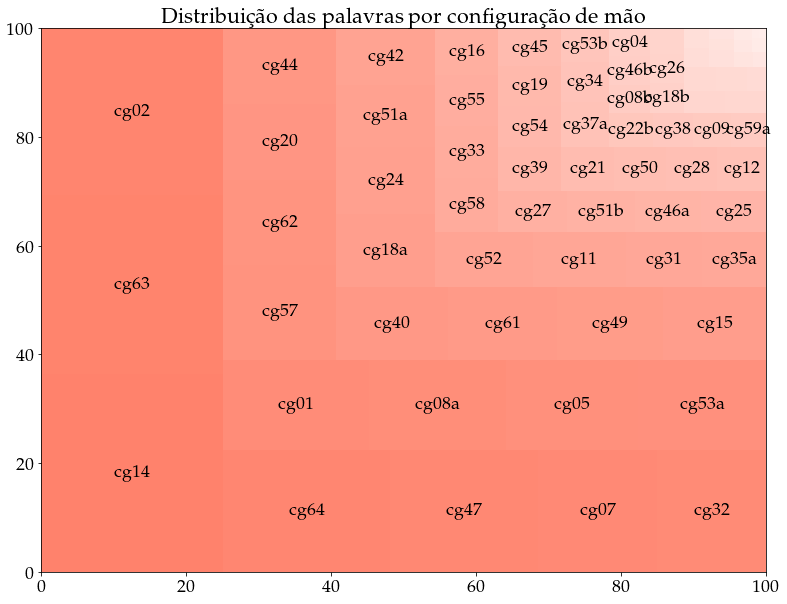

In [316]:
# #Create our plot and resize it.
# fig = plt.gcf()
# fig.set_size_inches(13, 10)

# values = countCM.values
# labels = countCM.index.values
# labels[values <= 13] = ""

# squarify.plot(sizes=values, label=labels, alpha=.8, color=colors2)
# plt.title('Distribuição das palavras por configuração de mão')
# # plt.axis('off')
# plt.show()

AttributeError: 'Rectangle' object has no property 'cmap'

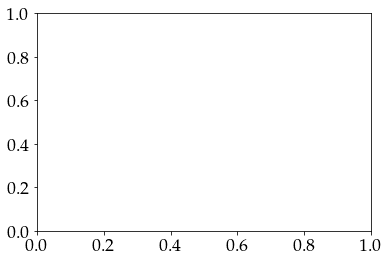

In [401]:
# values = countCG.values
# labels = countCG.index
# y_pos = np.arange(len(labels))

# fig, ax = plt.subplots()
# ax.bar(y_pos, values, cmap=cmap)
# ax.set_yscale("log")
# plt.xticks(y_pos, labels)
# plt.legend(labels,loc=2)
# plt.show()

In [61]:
CONNECTIONS = 30
TIMEOUT = 5
labels = np.unique(csv['CM'])
urls_CM = np.unique(csv['configuracao_mao'])
urls_videos = csv['video_url']
filenames = csv['filename']

In [82]:
def load_url_images(url, index, folder):
    r = requests.get(url, allow_redirects=True)
    open(folder + labels[index] + '.jpg', 'wb').write(r.content)
    
def load_url_videos(url, index, folder):
    r = requests.get(url, allow_redirects=True)
    open(folder + filenames[index], 'wb').write(r.content)
    
def getAllFiles (pathToFiles):
    files = []
    files = glob.glob(pathToFiles + '/*/*.mp4', recursive=True)
    return files

### Downloading video files

In [86]:
with concurrent.futures.ThreadPoolExecutor(max_workers=CONNECTIONS) as executor:
    future_to_url = {executor.submit(load_url_videos, url, index, "Videos/") : url for index, url in enumerate(urls_videos)}
    time1 = time.time()
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            data = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))
        finally:
            csv.loc[csv['video_url'] == url, 'downloaded'] = 'ok'
            print(str(len(out)),end="\r")
            
    time2 = time.time()

print(f'Took {time2-time1:.2f} s')
print(pd.Series(out).value_counts())

### Creating inner directories so as to organize videos by alphabetical order

In [87]:
path = "/home/fabiana/Desktop/projeto-final-src/Crawler/Videos"
pfPath = "/home/fabiana/Desktop/projeto-final-src/Crawler"
files = getAllFiles(path)

In [88]:
for file in files:
    filename = file.rsplit('/', 1)[1]
    letter = filename[0]
    if (not os.path.isdir(path + '/' + letter)):
        os.mkdir(path + '/' + letter)
    os.rename(file, path + '/' + letter + '/' + filename)

### Creating log to keep track of corrupted files

In [89]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, 
    format='%(asctime)s [%(levelname)s] - %(message)s',
    filename="/home/fabiana/Desktop/projeto-final-src/Crawler/corruptedFiles.log",
   filemode='w')

for file in files:
    cap = cv2.VideoCapture(file)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if (length < 1):
        logging.error('There are no frames in ' + file)
cap.release()